In [18]:
from dotenv import load_dotenv
load_dotenv(override=True)

True

## How to run Evaluations

#### Pytest / Vitest

[Pytest](https://docs.pytest.org/en/stable/) and Vitest are well known to many developers as a powerful tools for writing tests within the Python and JavaScript ecosystems. LangSmith integrates with these frameworks to allow you to write and run tests that log results to LangSmith. For this notebook, we'll use Pytest.
* Pytest is a great way to get started for developers who are already familiar with their framework. 
* Pytest is great for more complex evaluations, where each agent test case requires specific checks and success criteria that are harder to generalize.

#### LangSmith Datasets 

You can also create a dataset [in LangSmith](https://docs.smith.langchain.com/evaluation) and run our assistant against the dataset using the LangSmith evaluate API.
* LangSmith datasets are great for teams who are collaboratively building out their test suite. 
* You can leverage production traces, annotation queues, synthetic data generation, and more, to add examples to an ever-growing golden dataset.
* LangSmith datasets are great when you can define evaluators that can be applied to every test case in the dataset (ex. similarity, exact match accuracy, etc.)

## Test Cases

Testing often starts with defining the test cases, which can be a challenging process. In this case, we'll just define a set of example emails we want to handle along with a few things to test. You can see the test cases in `eval/email_dataset.py`, which contains the following:

1. **Input Emails**: A collection of diverse email examples
2. **Ground Truth Classifications**: `Respond`, `Notify`, `Ignore`
3. **Expected Tool Calls**: Tools called for each email that requires a response
4. **Response Criteria**: What makes a good response for emails requiring replies

Note that we have both
- End to end "integration" tests (e.g. Input Emails -> Agent -> Final Output vs Response Criteria)
- Tests for specific steps in our workflow (e.g. Input Emails -> Agent -> Classification vs Ground Truth Classification)


In [19]:

%load_ext autoreload
%autoreload 2

from email_assistant.eval.email_dataset import email_inputs, expected_tool_calls, triage_outputs_list, response_criteria_list

test_case_ix = 0

print("Email Input:", email_inputs[test_case_ix])
print("Expected Triage Output:", triage_outputs_list[test_case_ix])
print("Expected Tool Calls:", expected_tool_calls[test_case_ix])
print("Response Criteria:", response_criteria_list[test_case_ix])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Email Input: {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'Lance Martin <lance@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi Lance,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}
Expected Triage Output: respond
Expected Tool Calls: ['write_email', 'done']
Response Criteria: 
• Send email with write_email tool call to acknowledge the question and confirm it will be investigated  



## Pytest Example

Let's take a look at how we can write a test for a specific part of our workflow with Pytest. We will test whether our `email_assistant` makes the right tool calls when responding to the emails.

In [20]:
import pytest
from email_assistant.eval.email_dataset import email_inputs, expected_tool_calls
from email_assistant.utils import format_messages_string
from email_assistant.email_assistant import email_assistant
from email_assistant.utils import extract_tool_calls

from langsmith import testing as t

@pytest.mark.langsmith
@pytest.mark.parametrize(
    "email_input, expected_calls",
    [   # Pick some examples with e-mail reply expected
        (email_inputs[0],expected_tool_calls[0]),
        (email_inputs[3],expected_tool_calls[3]),
        (email_inputs[8],expected_tool_calls[8]),
    ],
)
def test_email_dataset_tool_calls(email_input, expected_calls):
    """Test if email processing contains expected tool calls.
    
    This test confirms that all expected tools are called during email processing,
    but does not check the order of tool invocations or the number of invocations
    per tool. Additional checks for these aspects could be added if desired.
    """
    # Run the email assistant
    messages = [{"role": "user", "content": str(email_input)}]
    result = email_assistant.invoke({"messages": messages})
            
    # Extract tool calls from messages list
    extracted_tool_calls = extract_tool_calls(result['messages'])
            
    # Check if all expected tool calls are in the extracted ones
    missing_calls = [call for call in expected_calls if call.lower() not in extracted_tool_calls]
    
    t.log_outputs({
                "missing_calls": missing_calls,
                "extracted_tool_calls": extracted_tool_calls,
                "response": format_messages_string(result['messages'])
            })

    # Test passes if no expected calls are missing
    assert len(missing_calls) == 0

You'll notice a few things. 
- To [run with Pytest and log test results to LangSmith](https://docs.smith.langchain.com/evaluation/how_to_guides/pytest), we only need to add the `@pytest.mark.langsmith ` decorator to our function and place it in a file, as you see in `notebooks/test_tools.py`. This will log the test results to LangSmith.
- Second, we can pass dataset examples to the test function as shown [here](https://docs.smith.langchain.com/evaluation/how_to_guides/pytest#parametrize-with-pytestmarkparametrize) via `@pytest.mark.parametrize`. 

#### Running Pytest
We can run the test from the command line. We've defined the above code in a python file. From the project root, run:

`! LANGSMITH_TEST_SUITE='Email assistant: Test Tools For Interrupt'  pytest notebooks/test_tools.py`

In [ ]:
import os

# Set the environment variable
os.environ['LANGSMITH_TEST_SUITE'] = 'Email assistant: Test Tools For Interrupt'

# Change to project root directory
project_root = r'd:\Ambient_Agents'
os.chdir(project_root)

# Run pytest with the correct path
!pytest notebooks/test_tools.py

#### Viewing Experiment Result

We can view the results in the LangSmith UI. The `assert len(missing_calls) == 0` is logged to the `Pass` column in LangSmith. The `log_outputs` are passed to the `Outputs` column and function arguments are passed to the `Inputs` column. Each input passed in `@pytest.mark.parametrize(` is a separate row logged to the `LANGSMITH_TEST_SUITE` project name in LangSmith, which is found under `Datasets & Experiments`.
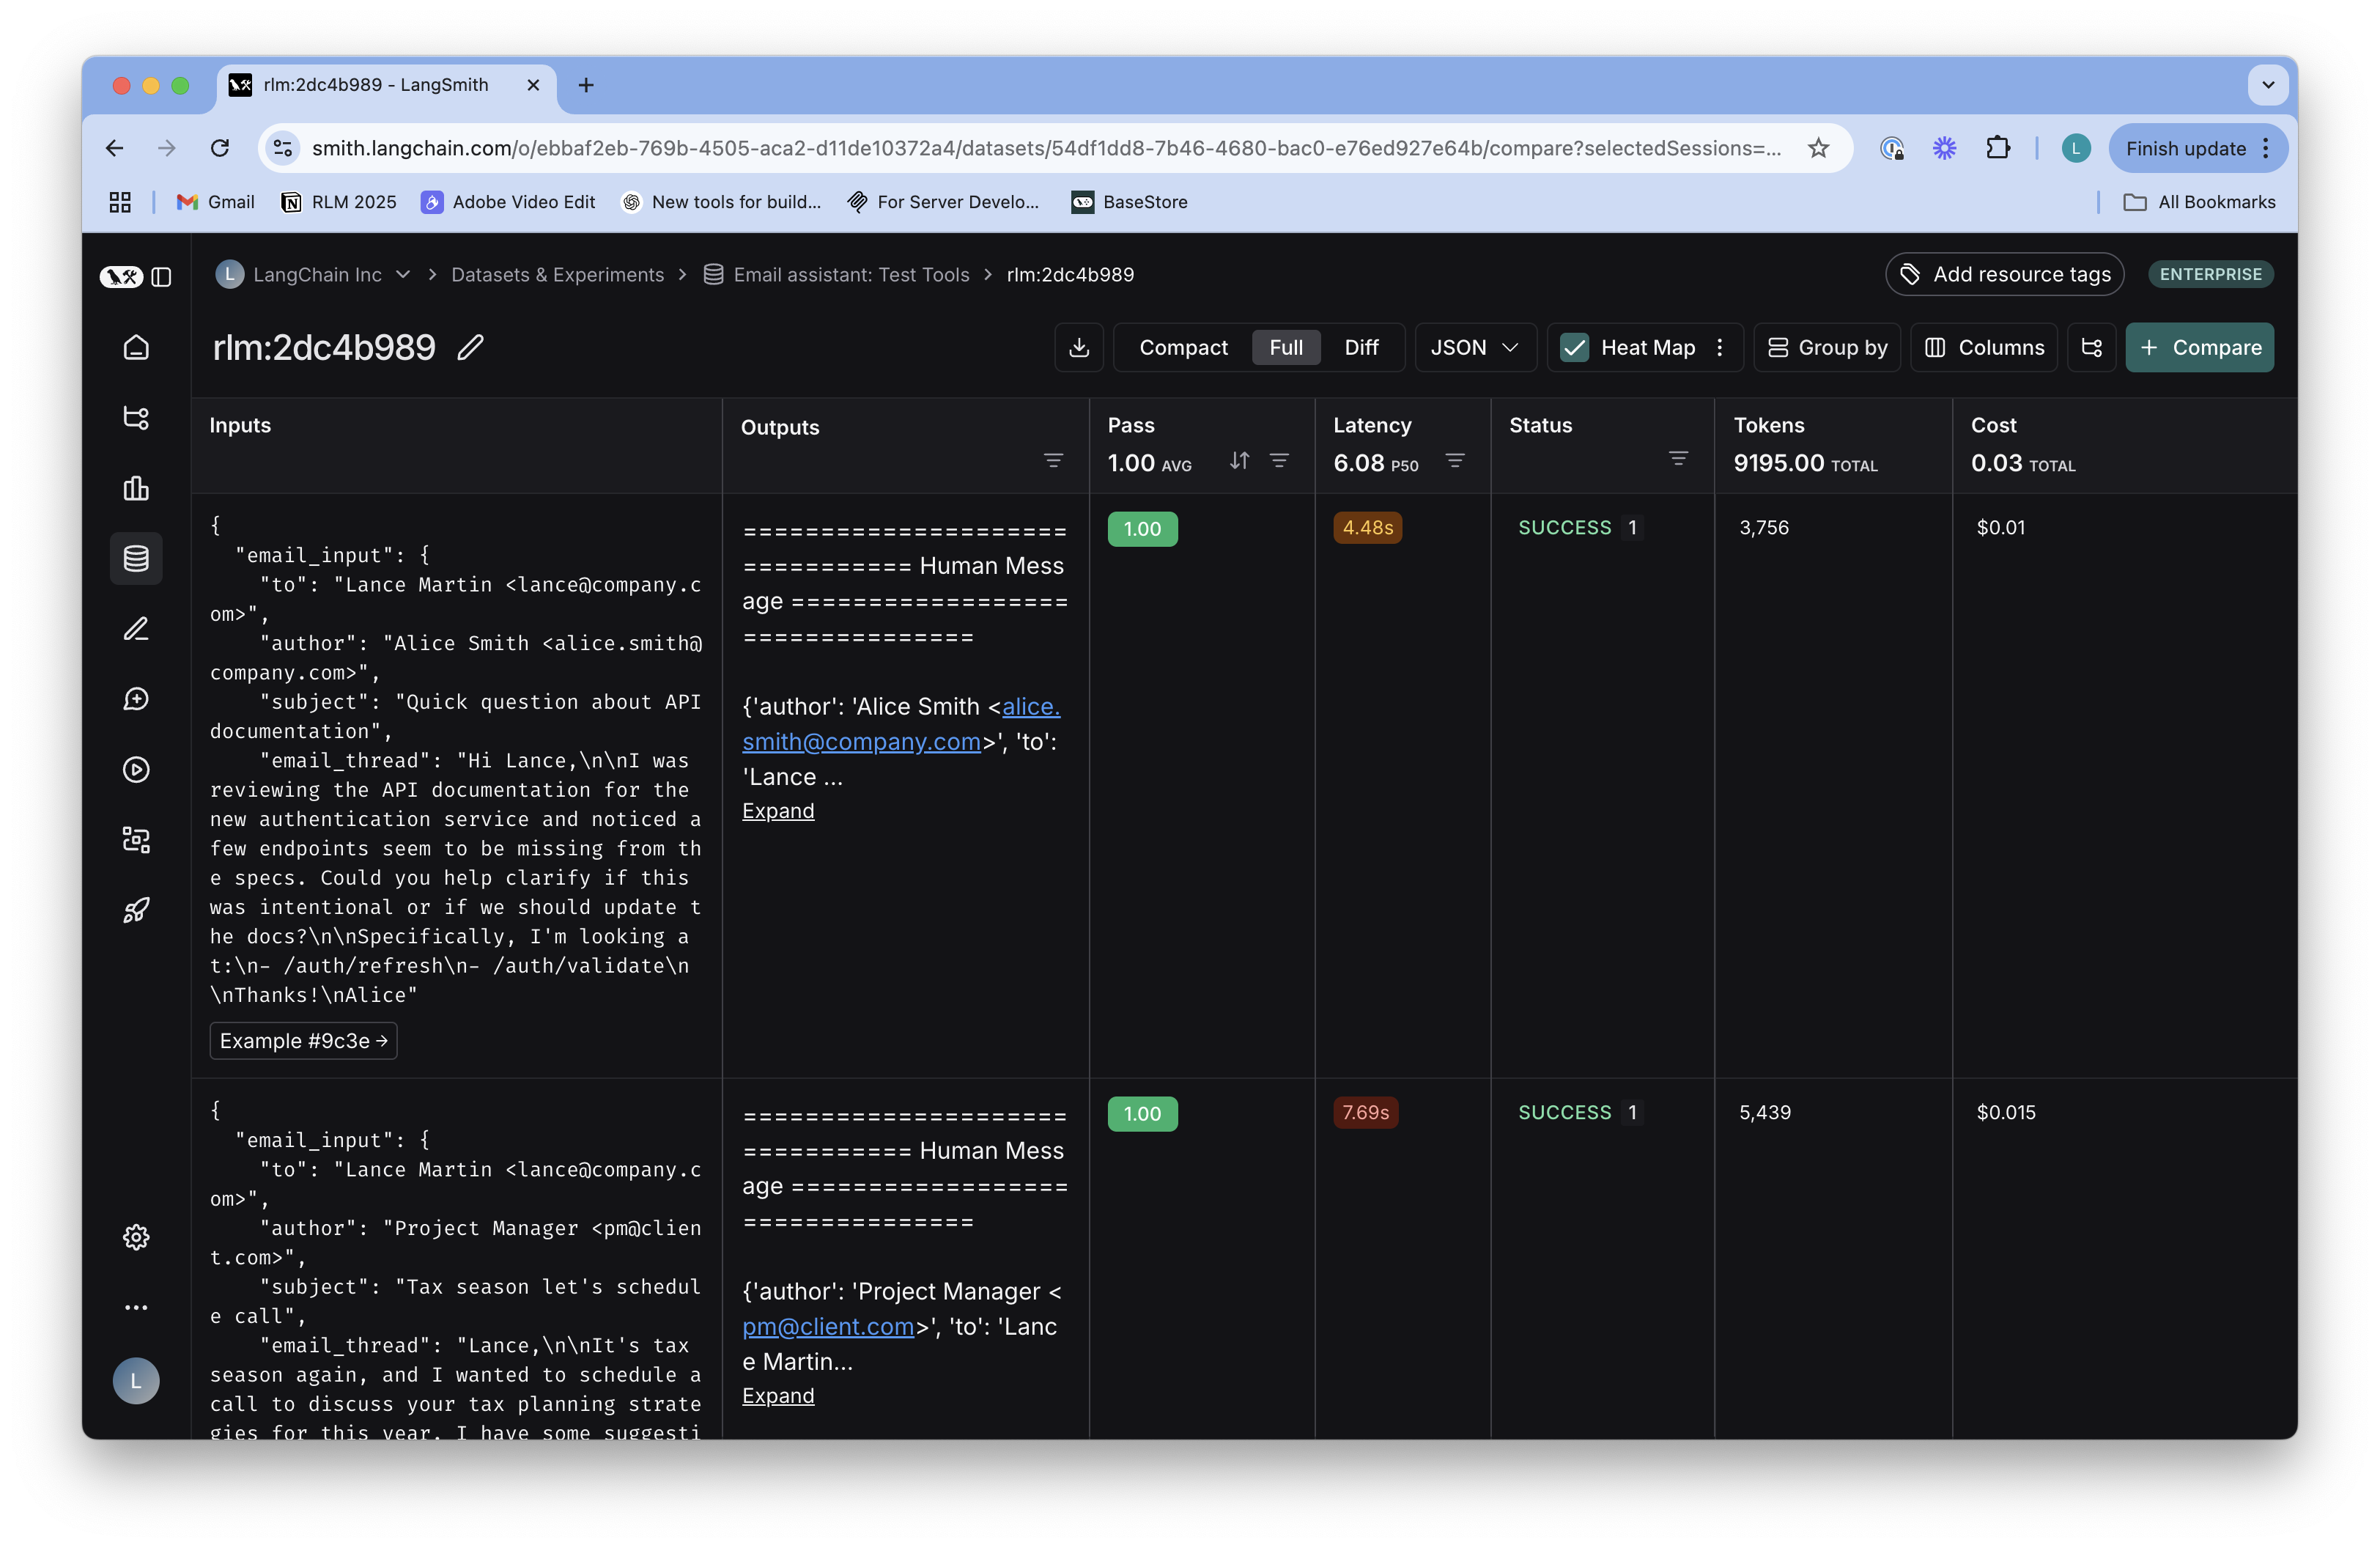


## LangSmith Datasets Example

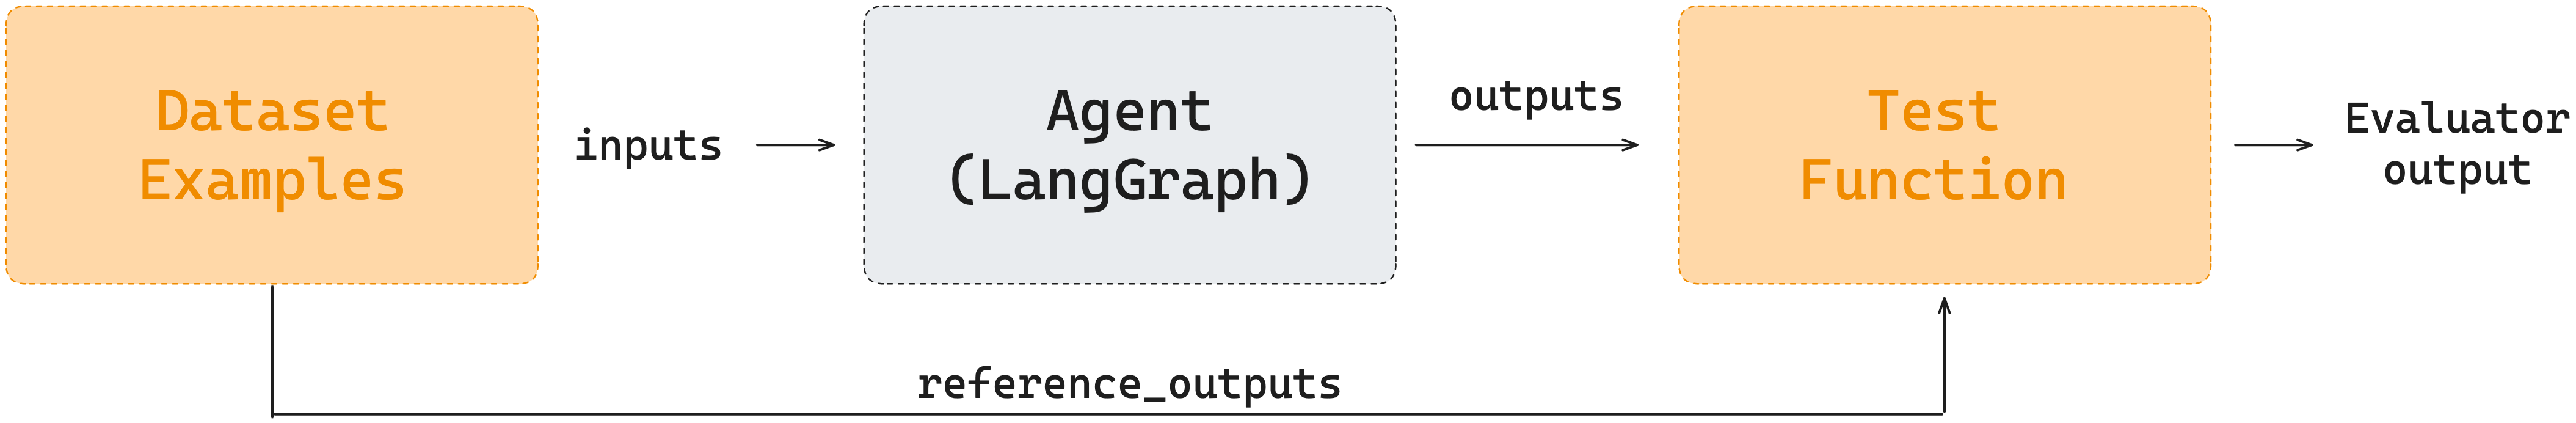

Let's take a look at how we can run evaluations with LangSmith datasets. In the previous example with Pytest, we evaluated the tool calling accuracy of the email assistant. Now, the dataset that we're going to evaluate here is specifically for the triage step of the email assistant, in classifying whether an email requires a response.

#### Dataset Definition 

We can [create a dataset in LangSmith](https://docs.smith.langchain.com/evaluation/how_to_guides/manage_datasets_programmatically#create-a-dataset) with the LangSmith SDK. The below code creates a dataset with the test cases in the `eval/email_dataset.py` file.

In [22]:
from langsmith import Client

from email_assistant.eval.email_dataset import examples_triage

# Initialize LangSmith client
client = Client()

# Dataset name
dataset_name = "E-mail Triage Evaluation"

# Create dataset if it doesn't exist
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(
        dataset_name=dataset_name, 
        description="A dataset of e-mails and their triage decisions."
    )
    # Add examples to the dataset
    client.create_examples(dataset_id=dataset.id, examples=examples_triage)

#### Target Function

The dataset has the following structure, with an e-mail input and a ground truth triage classification for the e-mail as output:

```
examples_triage = [
  {
      "inputs": {"email_input": email_input_1},
      "outputs": {"classification": triage_output_1},   # NOTE: This becomes the reference_output in the created dataset
  }, ...
]
```

In [23]:
print("Dataset Example Input (inputs):", examples_triage[0]['inputs'])


Dataset Example Input (inputs): {'email_input': {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'Lance Martin <lance@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi Lance,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}}


In [24]:
print("Dataset Example Reference Output (reference_outputs):", examples_triage[0]['outputs'])

Dataset Example Reference Output (reference_outputs): {'classification': 'respond'}


We define a function that takes the dataset inputs and passes them to our email assistant. The LangSmith [evaluate API](https://docs.smith.langchain.com/evaluation) passes the `inputs` dict to this function. This function then returns a dict with the agent's output. Because we are evaluating the triage step, we only need to return the classification decision. 

In [25]:
def target_email_assistant(inputs: dict) -> dict:
    """Process an email through the workflow-based email assistant."""
    response = email_assistant.nodes['triage_router'].invoke({"email_input": inputs["email_input"]})
    return {"classification_decision": response.update['classification_decision']}

#### Evaluator Function 

Now, we create an evaluator function. What do we want to evaluate? We have reference outputs in our dataset and agent outputs defined in the functions above.

* Reference outputs: `"reference_outputs": {"classification": triage_output_1} ...`
* Agent outputs: `"outputs": {"classification_decision": agent_output_1} ...`

We want to evaluate if the agent's output matches the reference output. So we simply need a an evaluator function that compares the two, where `outputs` is the agent's output and `reference_outputs` is the reference output from the dataset.

In [26]:
def classification_evaluator(outputs: dict, reference_outputs: dict) -> bool:
    """Check if the answer exactly matches the expected answer."""
    return outputs["classification_decision"].lower() == reference_outputs["classification"].lower()

### Running Evaluation

Now, the question is: how are these things hooked together? The evaluate API takes care of it for us. It passes the `inputs` dict from our dataset the target function. It passes the `reference_outputs` dict from our dataset to the evaluator function. And it passes the `outputs` of our agent to the evaluator function. 

Note this is similar to what we did with Pytest: in Pytest, we passed in the dataset example inputs and reference outputs to the test function with `@pytest.mark.parametrize`.

In [27]:
# Set to true if you want to kick off evaluation
run_expt = True
if run_expt:
    experiment_results_workflow = client.evaluate(
        # Run agent 
        target_email_assistant,
        # Dataset name   
        data=dataset_name,
        # Evaluator
        evaluators=[classification_evaluator],
        # Name of the experiment
        experiment_prefix="E-mail assistant workflow", 
        # Number of concurrent evaluations
        max_concurrency=2, 
    )

View the evaluation results for experiment: 'E-mail assistant workflow-050d55dc' at:
https://smith.langchain.com/o/9faebbef-5a1c-4f7f-874a-08e5c01d60d0/datasets/fe78085d-9f05-470a-9bc3-8315b4bd5883/compare?selectedSessions=7f6f124d-0e06-4ffb-a52a-91ed21a81d32




0it [00:00, ?it/s]

📧 Classification: RESPOND - This email requires a response
🔔 Classification: NOTIFY - This email contains important information
🚫 Classification: IGNORE - This email can be safely ignored
📧 Classification: RESPOND - This email requires a response
📧 Classification: RESPOND - This email requires a response
🚫 Classification: IGNORE - This email can be safely ignored
📧 Classification: RESPOND - This email requires a response
🔔 Classification: NOTIFY - This email contains important information
📧 Classification: RESPOND - This email requires a response
🔔 Classification: NOTIFY - This email contains important information
🔔 Classification: NOTIFY - This email contains important information
🔔 Classification: NOTIFY - This email contains important information
🚫 Classification: IGNORE - This email can be safely ignored
🔔 Classification: NOTIFY - This email contains important information
🚫 Classification: IGNORE - This email can be safely ignored
🔔 Classification: NOTIFY - This email contains impo

We can view the results from both experiments in the LangSmith UI.

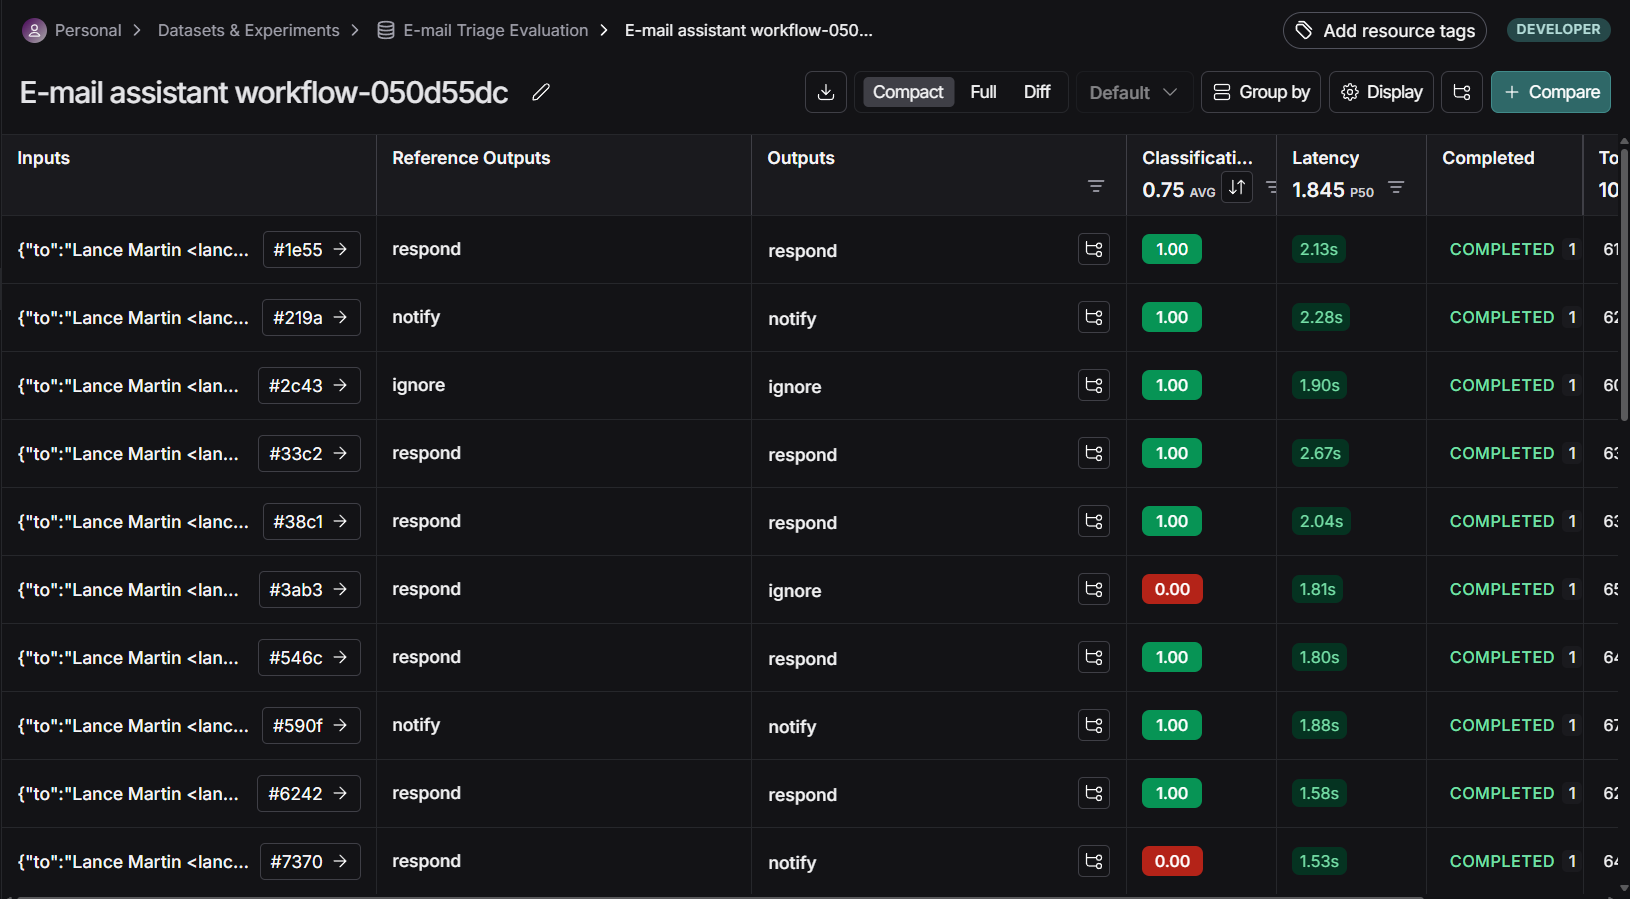

## LLM-as-Judge Evaluation

We've shown unit tests for the triage step (using evaluate()) and tool calling (using Pytest). 

We'll showcase how you could use an LLM as a judge to evaluate our agent's execution against a set of success criteria. 

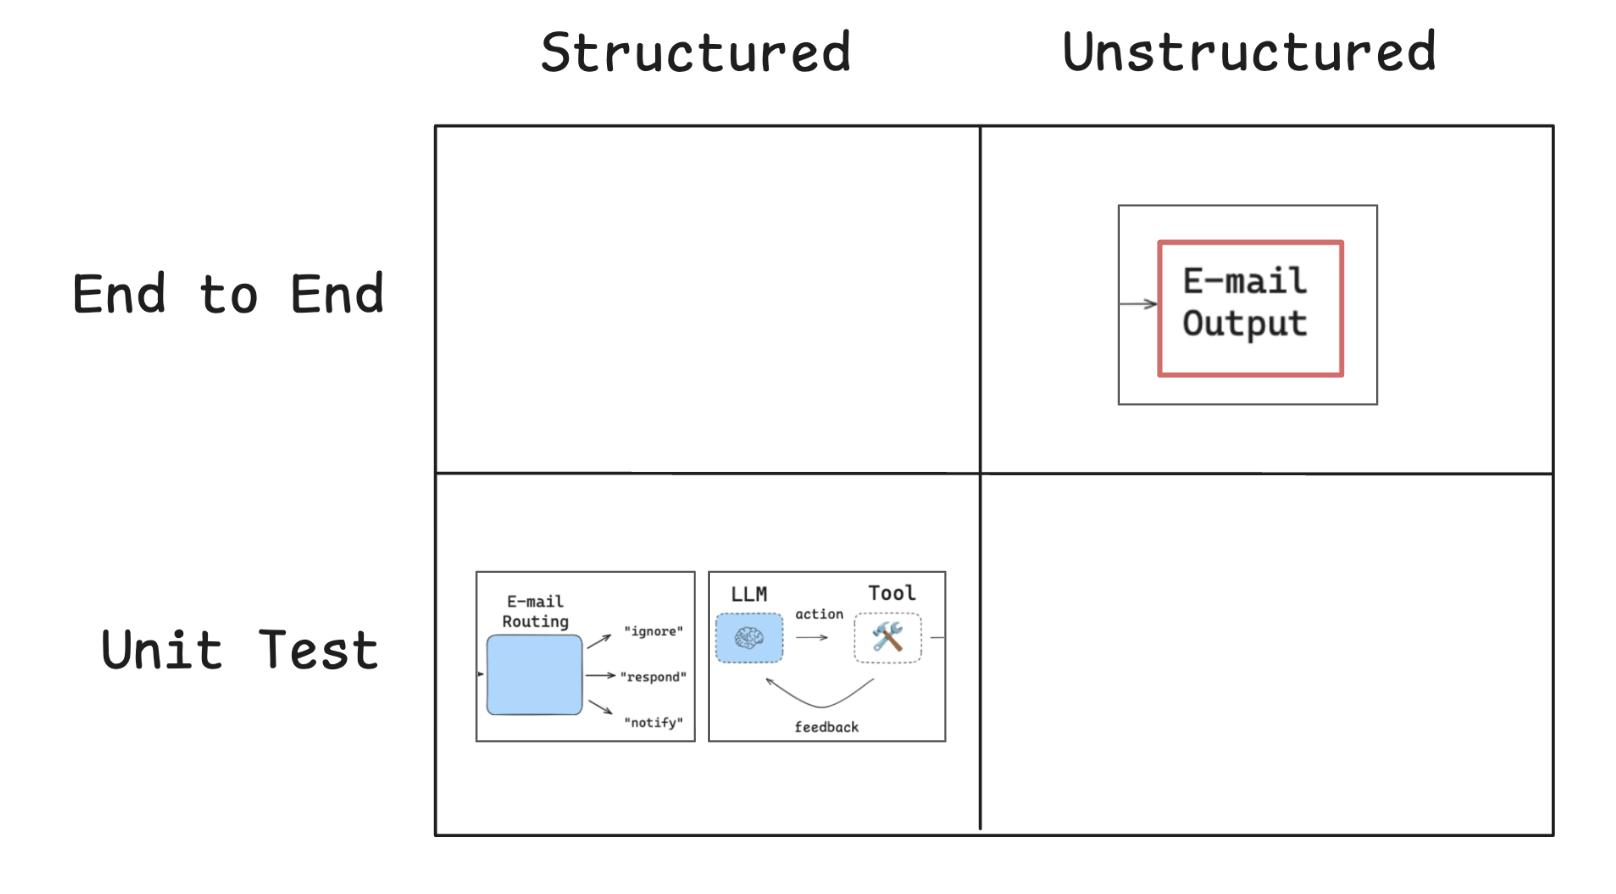

First, we define a structured output schema for our LLM grader that contains a grade and justification for the grade.

In [35]:
from pydantic import BaseModel, Field
from langchain.chat_models import init_chat_model

class CriteriaGrade(BaseModel):
    """Score the response against specific criteria."""
    justification: str = Field(description="The justification for the grade and score, including specific examples from the response.")
    grade: bool = Field(description="Does the response meet the provided criteria?")
    
# Create a global LLM for evaluation to avoid recreating it for each test
criteria_eval_llm = init_chat_model("openai:gpt-4o-mini")
criteria_eval_structured_llm = criteria_eval_llm.with_structured_output(CriteriaGrade)

In [36]:
email_input = email_inputs[0]
print("Email Input:", email_input)
success_criteria = response_criteria_list[0]
print("Success Criteria:", success_criteria)

Email Input: {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'Lance Martin <lance@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi Lance,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}
Success Criteria: 
• Send email with write_email tool call to acknowledge the question and confirm it will be investigated  



Our Email Assistant is invoked with the email input and the response is formatted into a string. These are all then passed to the LLM grader to receive a grade and justification for the grade.

In [30]:
response = email_assistant.invoke({"email_input": email_input})

📧 Classification: RESPOND - This email requires a response


In [31]:
from email_assistant.eval.prompts import RESPONSE_CRITERIA_SYSTEM_PROMPT

all_messages_str = format_messages_string(response['messages'])
eval_result = criteria_eval_structured_llm.invoke([
        {"role": "system",
            "content": RESPONSE_CRITERIA_SYSTEM_PROMPT},
        {"role": "user",
            "content": f"""\n\n Response criteria: {success_criteria} \n\n Assistant's response: \n\n {all_messages_str} \n\n Evaluate whether the assistant's response meets the criteria and provide justification for your evaluation."""}
    ])

eval_result

CriteriaGrade(justification='The assistant calls the write_email tool to send an email response to Alice Smith. The content of the email acknowledges her question regarding the missing endpoints in the API documentation and confirms that it will be investigated. The email states, "I will investigate the missing endpoints, /auth/refresh and /auth/validate, to determine if their absence from the API documentation was intentional or if updates are needed." This satisfies the requirement to send an email acknowledging the question and confirming it will be investigated.', grade=True)

In [34]:
from rich.markdown import Markdown
Markdown(RESPONSE_CRITERIA_SYSTEM_PROMPT)


You are evaluating an email assistant that works on behalf of a user.                                              

You will see a sequence of messages, starting with an email sent to the user.                                      

You will then see the assistant's response to this email on behalf of the user, which includes any tool calls made 
(e.g., write_email, schedule_meeting, check_calendar_availability, done).                                          

You will also see a list of criteria that the assistant's response must meet.                                      

Your job is to evaluate if the assistant's response meets ALL the criteria bullet points provided.                 

IMPORTANT EVALUATION INSTRUCTIONS:                                                                                 

 1 The assistant's response is formatted as a list of messages.                                                    
 2 The response criteria are formatted as bullet points (•)                                                        
 3 You must evaluate the response against EACH bullet point individually                                           
 4 ALL bullet points must be met for the response to receive a 'True' grade                                        
 5 For each bullet point, cite specific text from the response that satisfies or fails to satisfy it               
 6 Be objective and rigorous in your evaluation                                                                    
 7 In your justification, clearly indicate which criteria were met and which were not                              
 8 If ANY criteria are not met, the overall grade must be 'False'                                                  

Your output will be used for automated testing, so maintain a consistent evaluation approach.

We can see that the LLM grader returns an eval result with a schema matching our `CriteriaGrade` base model.

## Running against a Larger Test Suite
Now that we've seen how to evaluate our agent using Pytest and evaluate(), and seen an example of using an LLM as a judge, we can use evaluations over a bigger test suite to get a better sense of how our agent performs over a wider variety of examples.

Let's run our email_assistant against a larger test suite.
```
! LANGSMITH_TEST_SUITE='Email assistant: Test Full Response Interrupt' LANGSMITH_EXPERIMENT='email_assistant' pytest tests/test_response.py --agent-module email_assistant
```

In `test_response.py`, you can see a few things. 

We pass our dataset examples into functions that will run pytest and log to our `LANGSMITH_TEST_SUITE`:

```
# Reference output key
@pytest.mark.langsmith(output_keys=["criteria"])
# Variable names and a list of tuples with the test cases
# Each test case is (email_input, email_name, criteria, expected_calls)
@pytest.mark.parametrize("email_input,email_name,criteria,expected_calls",create_response_test_cases())
def test_response_criteria_evaluation(email_input, email_name, criteria, expected_calls):
```

We use LLM-as-judge with a grading schema:
```
class CriteriaGrade(BaseModel):
    """Score the response against specific criteria."""
    grade: bool = Field(description="Does the response meet the provided criteria?")
    justification: str = Field(description="The justification for the grade and score, including specific examples from the response.")
```


We evaluate the agent response relative to the criteria:
```
    # Evaluate against criteria
    eval_result = criteria_eval_structured_llm.invoke([
        {"role": "system",
            "content": RESPONSE_CRITERIA_SYSTEM_PROMPT},
        {"role": "user",
            "content": f"""\n\n Response criteria: {criteria} \n\n Assistant's response: \n\n {all_messages_str} \n\n Evaluate whether the assistant's response meets the criteria and provide justification for your evaluation."""}
    ])
```

Now let's take a look at this experiment in the LangSmith UI and look into what our agent did well, and what it could improve on.

#### Getting Results

We can also get the results of the evaluation by reading the tracing project associated with our experiment. This is great for creating custom visualizations of our agent's performance.

In [ ]:
import os

# Set the environment variable
os.environ['LANGSMITH_TEST_SUITE'] = 'Email assistant: Test Tools For Interrupt'

# Change to project root directory
project_root = r'd:\Ambient_Agents'
os.chdir(project_root)

# Run pytest with the correct path
!pytest tests/test_response.py

In [ ]:
# TODO: Copy your experiment name here
experiment_name = "email_assistant:8286b3b8"
# Set this to load expt results
load_expt = False
if load_expt:
    email_assistant_experiment_results = client.read_project(project_name=experiment_name, include_stats=True)
    print("Latency p50:", email_assistant_experiment_results.latency_p50)
    print("Latency p99:", email_assistant_experiment_results.latency_p99)
    print("Token Usage:", email_assistant_experiment_results.total_tokens)
    print("Feedback Stats:", email_assistant_experiment_results.feedback_stats)